# ***Common representation creation***

This notebook shows the preprocess of creating a common representation of each spectra.

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple
from os.path import join
from pathlib import Path
from matplotlib import pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from tqdm.notebook import tqdm

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "./DHG/"
# Define folder that contains level 0 data
LEVEL_0_PATH = f"{DHG_PATH}/level_0"
# Define folder to save level 1 data
LEVEL_1_PATH = f"{DHG_PATH}/level_1"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define path to save figures
FIGURES_PATH = "./figures/common_representation_creation"
# Define mass range start value
MZ_START = 50
# Define mass range end value
MZ_END = 1200
# Define mass resolution of the data
MASS_RESOLUTION = 0.025

### ***Creating output folder***

Next, let's create the output folder:

In [3]:
# Create output folder if doesn't exist
Path(LEVEL_1_PATH).mkdir(parents=True, exist_ok=True)
Path(FIGURES_PATH).mkdir(parents=True, exist_ok=True)

### ***Reading MSI metadata***

Next, lets read the metadata file:

In [4]:
# Read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

### ***Creating spectra binning class***

Next, lets create the class for binning a spectra:

In [5]:
class EqualWidthBinning():
  """Equal width spectra binning.

  """

  def __init__(self, mz_start: float, mz_end: float, bin_width: float) -> None:
    """__init__ method.

    Args:
        mz_start (float): Mz spectra range start.
        mz_end (float): Mz spectra range end.
        bin_width (float): Binning bin width.
    """
    super().__init__()

    # Calculate number of bins
    num_bins = int((mz_end - mz_start) / bin_width)
    # Create bin edges array of equal width bins from mz_start to
    # mz_end with bin_width
    self.bin_edges = np.around(np.linspace(mz_start, mz_end, num_bins + 1), 5)
    # Create bin centers array of equal width bins from mz_start to
    # mz_end with bin_width
    self.bin_centers = 0.5 * (self.bin_edges[1:] + self.bin_edges[:-1])

  def bin(
      self, spectra: Tuple[np.ndarray, np.ndarray]
  ) -> Tuple[np.ndarray, np.ndarray]:
    """Method to bin spectra

    Args:
        spectra (Tuple[np.ndarray, np.ndarray]): First element is mz values
        array of spectra and second element is the intensity values array
        of spectra.

    Returns:
        Tuple[np.ndarray, np.ndarray]: First element is mz values array of
        spectra and second element is normalized intensity values array
        of spectra.

    """
    # Unpack spectra
    mzs, intensities = np.copy(spectra)

    # If no mz values
    if np.array_equal(mzs, []):
      return self.bin_centers, np.zeros(self.bin_centers.shape)

    # Assign each mz value to its corresponding bin index
    bin_index = np.digitize(mzs, self.bin_edges)

    # Make sure index of spectra shape appears in bin_index
    # for shape consistency
    bin_index = np.append(bin_index, self.bin_centers.shape[0])
    intensities = np.append(intensities, 0)

    # Assign values beyond the bounds of bins to first and last bin
    # if they are smaller\larger than bounds respectively
    bin_index[bin_index == 0] = 1
    bin_index[bin_index == len(self.bin_edges)] = len(self.bin_edges) - 1

    # 0 index
    bin_index -= 1

    # Sum value of each bins
    bin_sums = np.bincount(bin_index, weights=intensities)

    return self.bin_centers, bin_sums

### ***Creating spectra normalization class***

Next, lets create the class for normalizing a spectra:

In [6]:
class TICNormalizer():
  """Total Ion Count normalizer.

  """

  @classmethod
  def normalize(
      cls, spectra: Tuple[np.ndarray, np.ndarray], epsilon: float = 0.001
  ) -> Tuple[np.ndarray, np.ndarray]:
    """Method to normalize a spectra

    Args:
        spectra (Tuple[np.ndarray, np.ndarray]): First element is the mz values
        array of spectra and second element is the intensity values array
        of spectra.
        epsilon (float): Small float added to denominator to avoid zero
        division.

    Returns:
        Tuple[np.ndarray, np.ndarray]: First element is the mz values array of
        spectra and second element is the normalized intensity values array
        of spectra.

    """
    # Unpack spectra
    mzs, intensities = np.copy(spectra)
    # Return tic normalized
    return (mzs, intensities / (intensities.sum() + epsilon))

### ***Creating spectra process pipeline***

Next, lets create the process pipeline for each spectra in the image:

In [7]:
# Get normalizer object
normalizer = TICNormalizer()
# Get binning object
binning = EqualWidthBinning(MZ_START, MZ_END, MASS_RESOLUTION / 2)
# Create process pipe
process_pipe = (
    lambda mzs, intensities:
    (binning.bin(normalizer.normalize((mzs, intensities))))
)

### ***Preprocess each MSI***

Next, let's process each MSI spectra. For each sample (ROI) we extract the sample from the MSI, and for each ROI we preprocess all spectra's using spectra preprocess pipeline:

In [8]:
# Loop over each ROI in data frame
for index, roi in tqdm(metadata_df.iterrows(),
                       total=metadata_df.shape[0],
                       desc="ROIs Loop"):
  # Parse the MSI file containing ROI
  with ImzMLParser(join(LEVEL_0_PATH, f"{roi.file_name}.imzML")) as reader:
    # Create a new MSI for ROI. because we apply binning
    # we can use mode="continuous"
    with ImzMLWriter(join(LEVEL_1_PATH,
                          f"{roi.sample_file_name}.imzML"),
                     mode="continuous") as writer:
      # Loop over each spectra in MSI
      for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                                 total=len(reader.coordinates),
                                 desc="Spectra Loop"):
        
        # Check if spectra is in ROI boundaries
        if ((roi.x_min <= x-1) & (roi.x_max >= x-1) & (roi.y_min <= y-1) &
            (roi.y_max >= y-1)):
          # Read spectra from MSI
          raw_mzs, raw_intensities = reader.getspectrum(idx)
          # Apply processing pipe
          preprocessed_mzs, preprocessed_intensities = process_pipe(
              raw_mzs, raw_intensities)
          # Write spectra to ROI MSI but by ROIs coordinates
          writer.addSpectrum(preprocessed_mzs, preprocessed_intensities,
                             (x - roi.x_min + 1, y - roi.y_min + 1, z))

ROIs Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/14022 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/14022 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/14022 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7482 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7482 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/14196 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/14196 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7938 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/7938 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/12920 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/12920 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/10220 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/10220 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/24024 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/24024 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/24024 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6095 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6095 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/27876 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/27876 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/27876 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/27876 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/27876 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/23718 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/23718 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/23718 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/23718 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/23718 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/10570 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/10570 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/10570 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5265 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5265 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/26207 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/26207 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/26207 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/26207 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/26207 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/26207 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/28584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/28584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/28584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/28584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/28584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/15045 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/15045 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6000 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/6000 [00:00<?, ?it/s]

c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession MS:1000526 found with incorrect name "Waters raw file". Updating name to "Waters raw format".
  warn(
c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
c:\Users\Leor\anaconda3\envs\tf_gpu_jup\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size". Updating name to "pixel size (x)".
  warn(


Spectra Loop:   0%|          | 0/4128 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4424 [00:00<?, ?it/s]

### ***Visualizing preprocess on single spectra***

Next, lets visualize the preprocess pipeline for a single spectra:

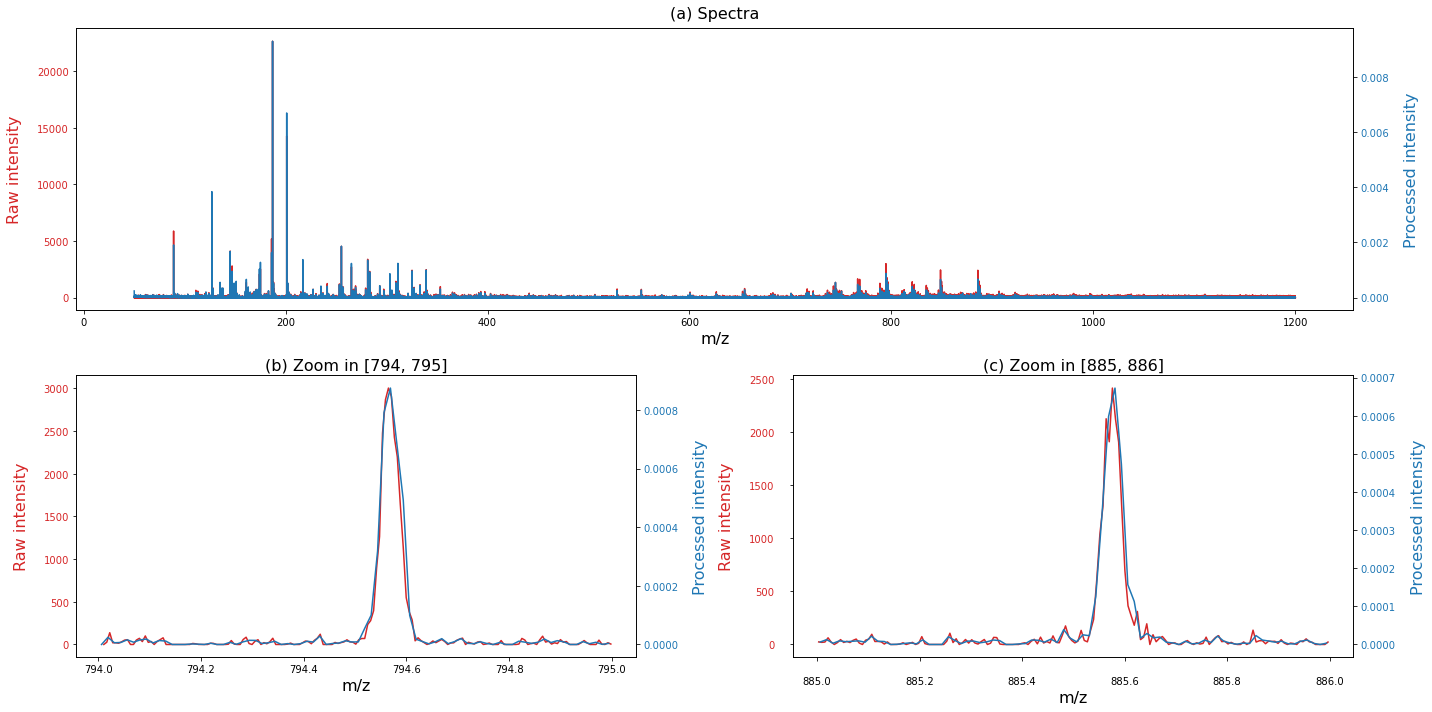

In [9]:
# Open parser
with ImzMLParser(
    join(LEVEL_0_PATH, f"{metadata_df.file_name[3]}.imzML")
) as reader:
  # Get single spectra
  raw_mzs, raw_intensities = reader.getspectrum(2999)

  # Process spectrum
  preprocessed_mzs, preprocessed_intensities = process_pipe(
      raw_mzs, raw_intensities
  )

  # Create plot
  fig = plt.figure(figsize=(20, 10))

  # Define colors for lines
  color_raw = "tab:red"
  color_preprocessed = "tab:blue"

  # Get zoom in area for top left plot
  lower_1 = 794
  upper_1 = 795
  idx_1_1 = (raw_mzs >= lower_1) & (raw_mzs <= upper_1)
  idx_1_2 = (preprocessed_mzs >= lower_1) & (preprocessed_mzs <= upper_1)

  # Get zoom in area for top right plot
  lower_2 = 885
  upper_2 = 886
  idx_2_1 = (raw_mzs >= lower_2) & (raw_mzs <= upper_2)
  idx_2_2 = (preprocessed_mzs >= lower_2) & (preprocessed_mzs <= upper_2)

  # Top Plot
  sub1_1 = fig.add_subplot(2, 2, (1, 2))
  sub1_1.plot(raw_mzs, raw_intensities, color=color_raw)
  sub1_1.tick_params(axis="y", labelcolor=color_raw)
  sub1_1.set_xlabel("m/z", fontsize=16)
  sub1_1.set_ylabel("Raw intensity", color=color_raw, labelpad=15, fontsize=16)

  sub1_2 = sub1_1.twinx()
  sub1_2.plot(
      preprocessed_mzs, preprocessed_intensities, color=color_preprocessed
  )
  sub1_2.tick_params(axis="y", labelcolor=color_preprocessed)
  sub1_2.set_ylabel(
      "Processed intensity", color=color_preprocessed, labelpad=15,
      fontsize=16
  )

  # Bottom left plot
  sub2_1 = fig.add_subplot(2, 2, 3)
  sub2_1.plot(raw_mzs[idx_1_1], raw_intensities[idx_1_1], color=color_raw)
  sub2_1.tick_params(axis="y", labelcolor=color_raw)
  sub2_1.set_xlabel("m/z", fontsize=16)
  sub2_1.set_ylabel("Raw intensity", color=color_raw, labelpad=15, fontsize=16)

  sub2_2 = sub2_1.twinx()
  sub2_2.plot(
      preprocessed_mzs[idx_1_2], preprocessed_intensities[idx_1_2],
      color=color_preprocessed
  )
  sub2_2.tick_params(axis="y", labelcolor=color_preprocessed)
  sub2_2.set_ylabel(
      "Processed intensity", color=color_preprocessed, labelpad=15,
      fontsize=16
  )

  # Bottom right plot
  sub3_1 = fig.add_subplot(2, 2, 4)
  sub3_1.plot(raw_mzs[idx_2_1], raw_intensities[idx_2_1], color=color_raw)
  sub3_1.tick_params(axis="y", labelcolor=color_raw)
  sub3_1.set_xlabel("m/z", fontsize=16)
  sub3_1.set_ylabel("Raw intensity", color=color_raw, labelpad=15, fontsize=16)

  sub3_2 = sub3_1.twinx()
  sub3_2.plot(
      preprocessed_mzs[idx_2_2], preprocessed_intensities[idx_2_2],
      color=color_preprocessed
  )
  sub3_2.tick_params(axis="y", labelcolor=color_preprocessed)
  sub3_2.set_ylabel(
      "Processed intensity", color=color_preprocessed, labelpad=15,
      fontsize=16
  )

  # Plots titles
  sub1_1.set_title("(a) Spectra", pad=10, fontsize=16)
  sub2_1.set_title(f"(b) Zoom in [{lower_1}, {upper_1}]", fontsize=16)
  sub3_1.set_title(f"(c) Zoom in [{lower_2}, {upper_2}]", fontsize=16)
  sub3_1.tick_params(pad=15)

  # Show plot
  plt.tight_layout()
  plt.savefig(
      f"{FIGURES_PATH}/single_spectra_preprocess.png", transparent=True
  )
  plt.show()

  # Save data for plot creation
  pd.Series(raw_intensities, index=raw_mzs
           ).to_csv(f"{FIGURES_PATH}/raw_spectra.csv", header=False)
  pd.Series(preprocessed_intensities, index=preprocessed_mzs
           ).to_csv(f"{FIGURES_PATH}/preprocessed_spectra.csv", header=False)